# Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from faker import Faker
from random import randint, choice
from datetime import datetime, timedelta

# Generating Dataset

In [ ]:
fake = Faker()
np.random.seed(42)
Faker.seed(42)

num_customers = 10000
num_sessions = 100000

genders = ['Male', 'Female']
locations = ['Accra', 'Takoradi', 'Sekondi', 'Tamale', 'Wa', 'Bolgatanga']
devices = ['Desktop', 'Mobile', 'Tablet']
payment_methods = ['Credit Card', 'Mobile Money', 'Cash on Delivery']
product_categories = ['Kitchen Appliances', 'Clothing', 'Home', 'Bathroom', 'Footwears']



customers = []
for i in range(num_customers):
    customers.append({
        'customer_id': f"CUST{i:05d}",
        'age': randint(18, 70),
        'gender': choice(genders),
        'location': choice(locations),
        'customer_since': fake.date_between(start_date='-5y', end_date='-1y')
    })
customers_df = pd.DataFrame(customers)


sessions = []
for i in range(num_sessions):
    cust = customers_df.sample(1).iloc[0]
    session_start = fake.date_time_between(start_date='-1y', end_date='now')
    duration = timedelta(minutes=randint(1, 60))
    session_end = session_start + duration
    viewed = randint(1, 10)
    added = randint(0, viewed)
    purchased = randint(0, added)
    total_spent = round(purchased * randint(10, 100), 2)
    churned = 1 if (datetime.now() - session_end).days > 60 and purchased == 0 else 0

    sessions.append({
        'session_id': f"SESS{i:06d}",
        'customer_id': cust['customer_id'],
        'session_start': session_start,
        'session_end': session_end,
        'pages_viewed': viewed + randint(1, 5),
        'product_categories_viewed': choice(product_categories),
        'products_added_to_cart': added,
        'products_purchased': purchased,
        'total_spent': total_spent,
        'device_type': choice(devices),
        'payment_method': choice(payment_methods),
        'last_active_date': session_end,
        'churned': churned
    })

sessions_df = pd.DataFrame(sessions)

In [4]:
df = sessions_df.merge(customers_df, on='customer_id')
df.to_csv("ecommerce_data.csv", index=False)
print("ecommerce_data.csv has been created with", len(df), "rows.")


ecommerce_data.csv has been created with 100000 rows.


# 1.	Data Analysis

In [5]:
df = pd.read_csv("ecommerce_data.csv", parse_dates=["session_start", "session_end", "customer_since", "last_active_date"])
df.head()

,session_id,customer_id,session_start,session_end,pages_viewed,product_categories_viewed,products_added_to_cart,products_purchased,total_spent,device_type,payment_method,last_active_date,churned,age,gender,location,customer_since
0,SESS000000,CUST06252,2024-11-15 05:48:45,2024-11-15 05:49:45,8,Kitchen Appliances,0,0,0,Mobile,Credit Card,2024-11-15 05:49:45,1,32,Female,Accra,2023-07-10
1,SESS000001,CUST06366,2025-01-26 06:56:48,2025-01-26 07:38:48,10,Footwears,1,1,53,Tablet,Mobile Money,2025-01-26 07:38:48,0,33,Male,Accra,2021-09-09
2,SESS000002,CUST08740,2025-02-15 11:44:42,2025-02-15 12:15:42,15,Footwears,4,1,40,Tablet,Credit Card,2025-02-15 12:15:42,0,57,Female,Sekondi,2021-12-06
3,SESS000003,CUST04449,2024-08-29 02:37:31,2024-08-29 03:17:31,7,Home,5,2,40,Desktop,Credit Card,2024-08-29 03:17:31,0,21,Female,Tamale,2020-09-11
4,SESS000004,CUST08718,2025-02-17 23:27:53,2025-02-18 00:08:53,5,Clothing,4,1,28,Desktop,Credit Card,2025-02-18 00:08:53,0,19,Female,Bolgatanga,2022-06-02


In [6]:
# Basic shape and data types
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.info()

# Summary statistics
df.describe(include='all').T

# Missing values
df.isnull().sum()

# Duplicate checks
df.duplicated().sum()


Rows: 100000, Columns: 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   session_id                 100000 non-null  object        
 1   customer_id                100000 non-null  object        
 2   session_start              100000 non-null  datetime64[ns]
 3   session_end                100000 non-null  datetime64[ns]
 4   pages_viewed               100000 non-null  int64         
 5   product_categories_viewed  100000 non-null  object        
 6   products_added_to_cart     100000 non-null  int64         
 7   products_purchased         100000 non-null  int64         
 8   total_spent                100000 non-null  int64         
 9   device_type                100000 non-null  object        
 10  payment_method             100000 non-null  object        
 11  last_active_date           

0

# 2.	Feature Engineering:

In [ ]:
df['session_duration'] = (df['session_end'] - df['session_start']).dt.total_seconds() / 60

df['days_since_last_active'] = (pd.Timestamp.now() - df['last_active_date']).dt.days

df['spend_per_product'] = df['total_spent'] / df['products_purchased'].replace(0, np.nan)

df[['session_duration', 'days_since_last_active', 'spend_per_product']].describe()

,session_duration,days_since_last_active,spend_per_product
count,100000.000000,100000.00000,56796.000000
mean,30.510260,182.13695,54.872192
std,17.310587,105.46436,26.254250
min,1.000000,-1.00000,10.000000
25%,16.000000,91.00000,32.000000
50%,31.000000,182.00000,55.000000
75%,45.000000,273.00000,78.000000
max,60.000000,365.00000,100.000000


# 3.	Predictive Modeling:

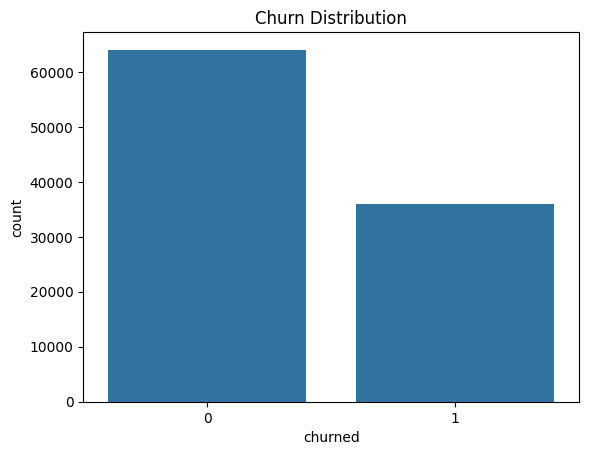

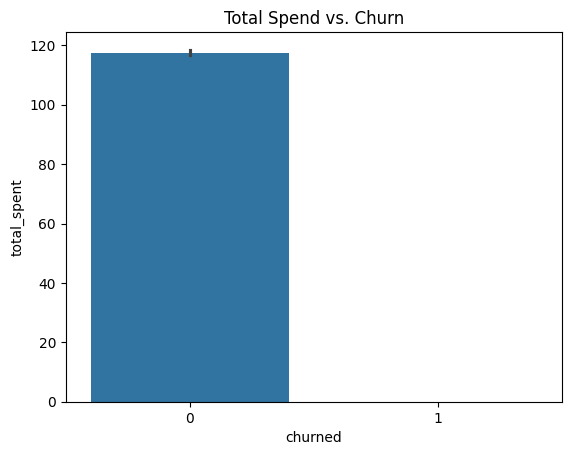

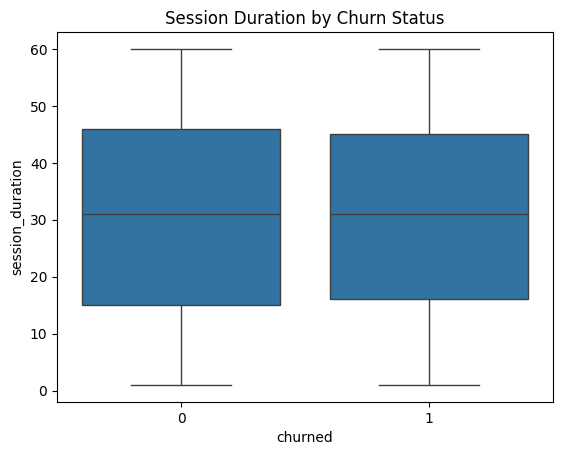

In [8]:
# Churn distribution
sns.countplot(data=df, x='churned')
plt.title("Churn Distribution")
plt.show()

# Average spend by churn
sns.barplot(data=df, x='churned', y='total_spent')
plt.title("Total Spend vs. Churn")
plt.show()

# Session duration vs. purchases
sns.boxplot(data=df, x='churned', y='session_duration')
plt.title("Session Duration by Churn Status")
plt.show()


In [ ]:
features = ['age', 'session_duration', 'pages_viewed', 'products_added_to_cart', 'products_purchased', 'total_spent']
X = df[features].fillna(0)
y = df['churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.89      0.93     12740
           1       0.83      0.94      0.88      7260

    accuracy                           0.91     20000
   macro avg       0.90      0.92      0.91     20000
weighted avg       0.92      0.91      0.91     20000



# 4.	Big Data Tool Utilization: Connecting to Elasticsearch

In [ ]:
! pip install elasticsearch==8.13.2

In [ ]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

df = pd.read_csv("ecommerce_data.csv")
es = Elasticsearch("http://localhost:9200")

es.indices.create(index="ecommerce")

def df_to_elasticsearch_docs(df):
    for i, row in df.iterrows():
        yield {
            "_index": "ecommerce",
            "_id": i,
            "_source": row.to_dict()
        }
bulk(es, df_to_elasticsearch_docs(df))
print("Data uploaded to Elasticsearch!")


Data uploaded to Elasticsearch successfully!


In [ ]:
! pip show elasticsearch

Name: elasticsearch
Version: 8.13.2
Summary: Python client for Elasticsearch
Home-page: https://github.com/elastic/elasticsearch-py
Author: Elastic Client Library Maintainers
Author-email: client-libs@elastic.co
License: Apache-2.0
Location: C:\Users\Nana Aba_ Remotown\anaconda3\Lib\site-packages
Requires: elastic-transport
Required-by: 


In [ ]:
print(es.count(index="ecommerce"))     
print(es.search(index="ecommerce", size=1))  

{'count': 100000, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}
{'took': 920, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'ecommerce', '_id': '3661', '_score': 1.0, '_source': {'session_id': 'SESS003661', 'customer_id': 'CUST04381', 'session_start': '2024-11-14 10:29:35', 'session_end': '2024-11-14 10:55:35', 'pages_viewed': 4, 'product_categories_viewed': 'Home', 'products_added_to_cart': 2, 'products_purchased': 0, 'total_spent': 0, 'device_type': 'Desktop', 'payment_method': 'Mobile Money', 'last_active_date': '2024-11-14 10:55:35', 'churned': 1, 'age': 43, 'gender': 'Female', 'location': 'Tamale', 'customer_since': '2023-06-18'}}]}}


In [10]:
query = {
    "size": 0,
    "aggs": {
        "gender_distribution": {
            "terms": {
                "field": "gender.keyword"
            }
        }
    }
}

response = es.search(index="ecommerce", body=query)
print(response["aggregations"]["gender_distribution"]["buckets"])


[{'key': 'Male', 'doc_count': 50532}, {'key': 'Female', 'doc_count': 49468}]
